# Victoria Metrics

In [66]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, graphviz_layout

import utilities.stats as stats
import utilities.graphs as graphs
import utilities.sqlite_helper as helper

In [67]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)
print("Updates imports")

Updates imports


In [68]:
# CONSTANTS
NON_PROJECT_NODES = ["runtime", "testing"]

TODOS:
[] Failed benchmarks also need to be removed from full graph
[] remove split thing everywhere

#### Helpers

In [69]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

def get_name_from_db_bench(name):
    return name.replace("/", "-")

In [70]:
def change(rl: float, ru: float):
    if ru < 1:
        return (1-ru) * 100
    elif rl > 1:
        return (rl-1) * 100
    else:
        return 0

In [71]:
# Hierachical Bootstrap
def boostrap_ratio_mean_laaber(benchmark: dict, num_iterations: int=10000):
    bootstrap_mean = []
    for _ in range(num_iterations):
        samples = []
        trials = list(benchmark.keys())
        for _ in trials:
            # Pick random trial
            random_trial = np.random.choice(trials, replace=True)
            iterations = list(benchmark[random_trial])
            
            for _ in iterations:
                # Pick random iteration
                random_iteration_idx = np.random.choice(len(iterations), replace=True)
                ns = iterations[random_iteration_idx][2]
                samples.append(ns)

        bootstrap_mean.append(np.mean(samples))  
    return bootstrap_mean          


# Loading Data for instability

In [72]:
db_path_tags = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/sqlite-database.db"

In [73]:
measurements = helper.get_all_measurements(db_path_tags, start_form_count=0)

# group by tag/version
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

# group by benchmark name
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_28 0.6802182915746167
v1.89.0 BenchmarkMapHasHitRandomLastBits/lastBits_32 0.5281200733323842
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_20 1.5448311730200015
v1.89.0 BenchmarkRowsUnmarshal 0.8675993697510348
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_32 1.0009678829085884
v1.89.0 BenchmarkMapHasHitRandomLastBits/lastBits_28 0.7440170852793558
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",i!~"2.*",j="foo" 0.5791547890241965
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",i!="2",j="foo" 0.6092098011390488
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_24 1.1304046952315279
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",j!="foo" 0.5195120892073789
v1.89.0 BenchmarkHeadPostingForMatchers/i=~".*" 0.616276185556814
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",j="foo" 0.58083922422006
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".*",i!="2",j="foo" 0.9078822914876125
v1.89.0 BenchmarkHeadPostingForMa

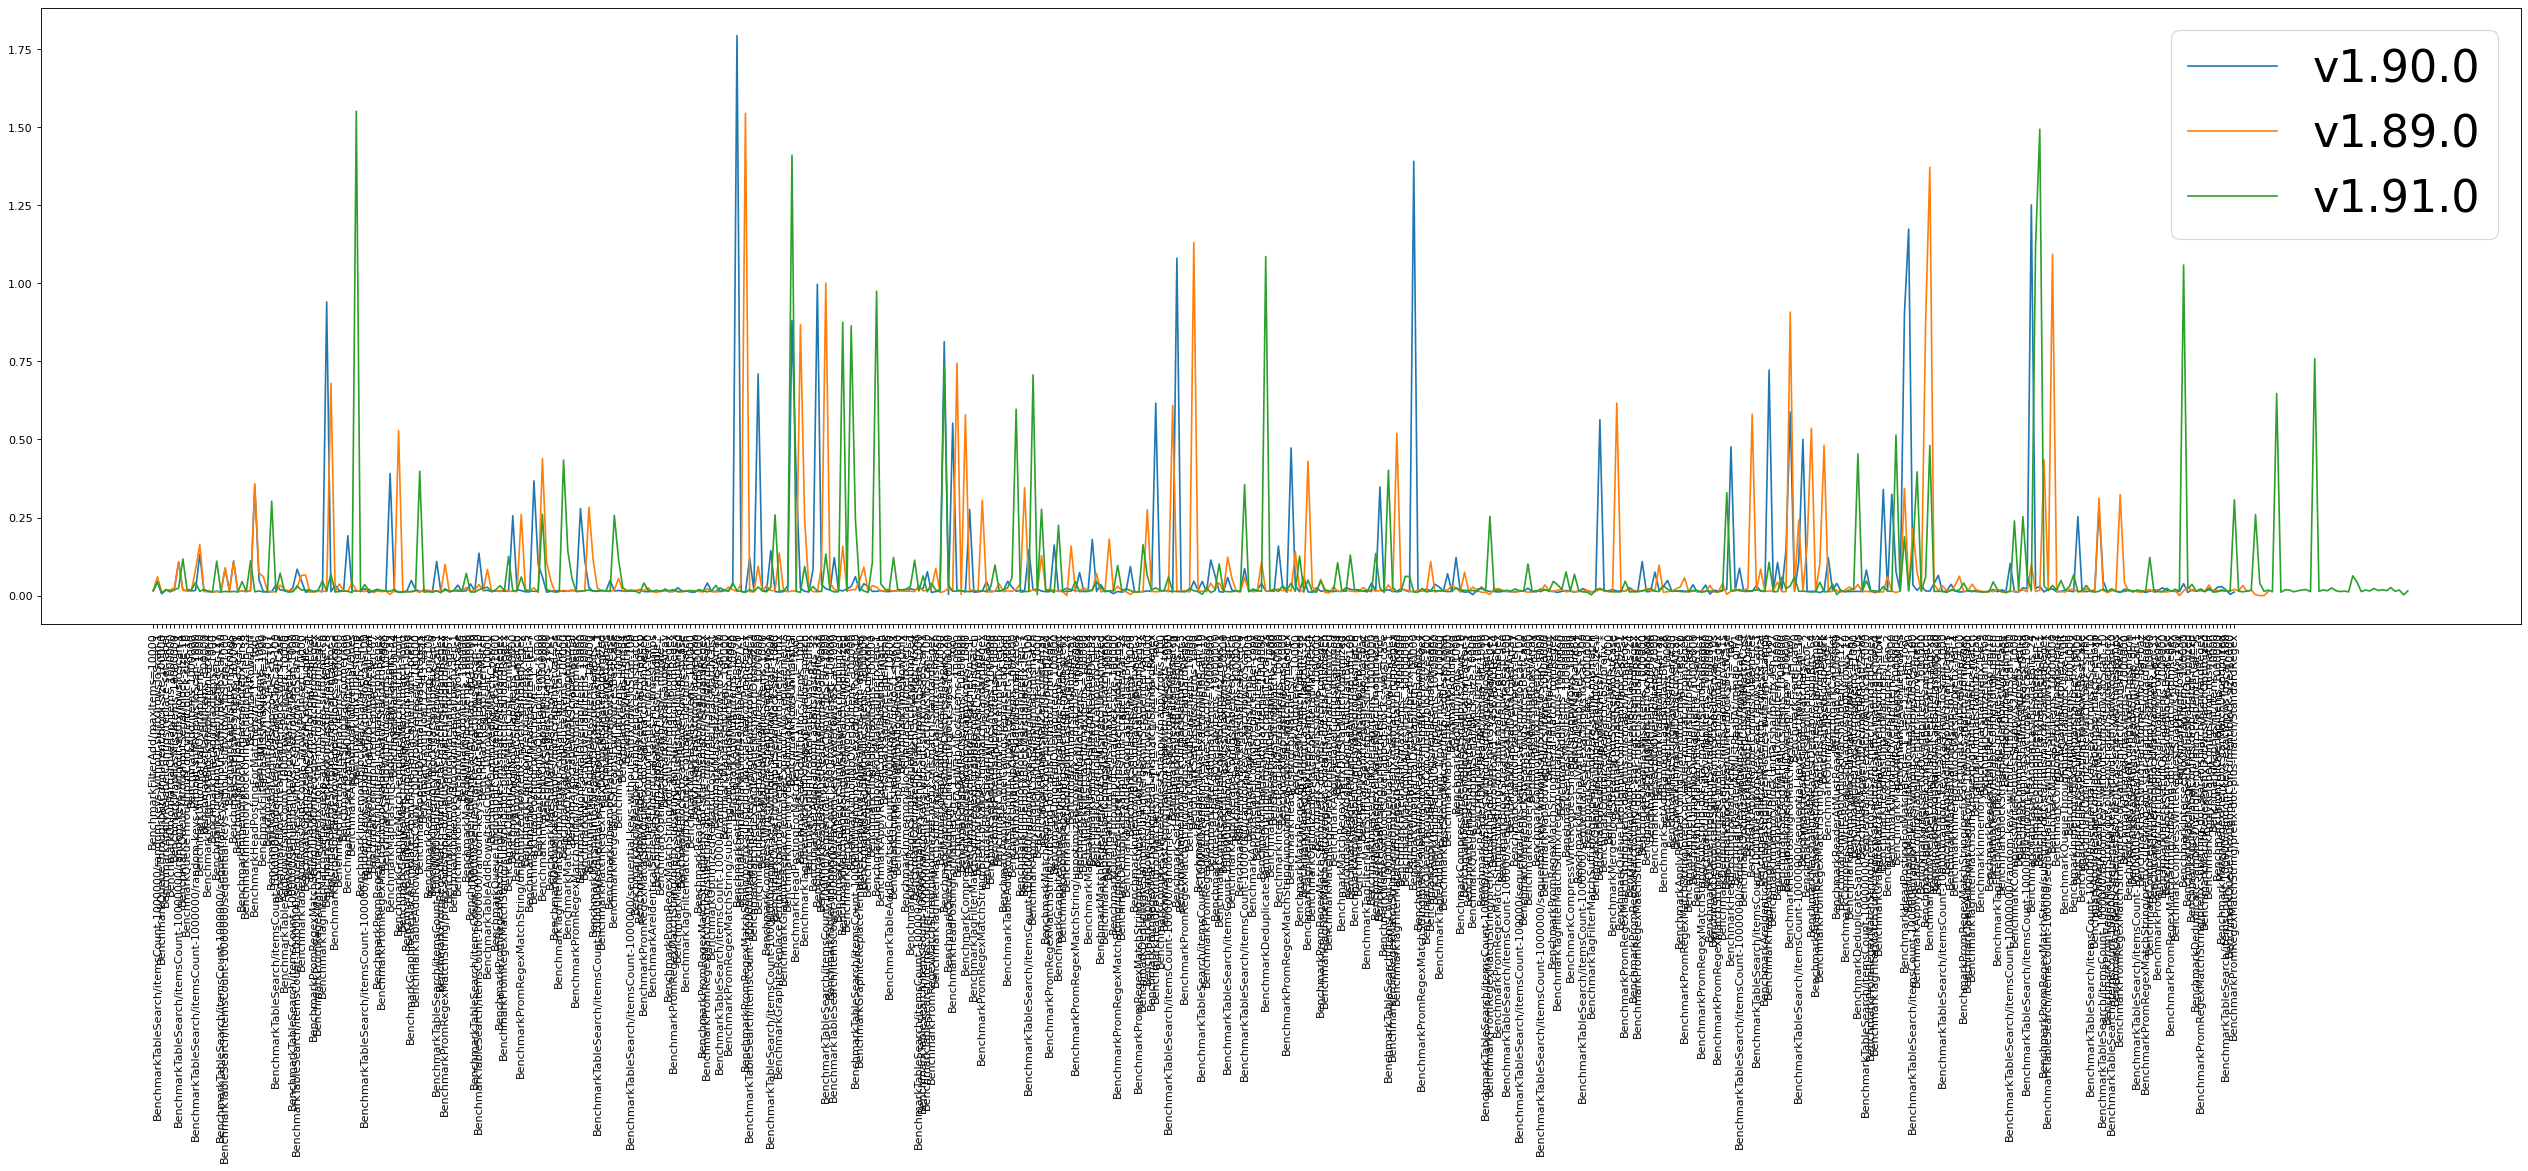

In [74]:
unstable_benchmarks = []
stability_measures = {}

plt.figure(figsize=(40, 10), dpi=80)

labels=list(next(iter(grouped_by_tag.values())).keys())
plt.xticks([x for x in range(len(labels))], labels, rotation='vertical')

for tag in grouped_by_tag.keys():
    cv = []
    spread = []
    for bench in grouped_by_tag[tag].keys():
        x = []
        measurments = grouped_by_tag[tag][bench]
        for entry in measurments:
            x.append(entry[2])
        current_cv = stats.cv(x)
        cv.append(current_cv)
        try:
            stability_measures[get_name_from_db_bench(bench)].append(current_cv)
        except KeyError:
            stability_measures[get_name_from_db_bench(bench)] = [current_cv]

        if (current_cv) > 0.5 and tag == "v1.89.0":
            print(f"{tag} {bench} {current_cv}")
            unstable_benchmarks.append(get_name_from_db_bench(bench))
        spread.append(stats.max_spread(x))

    plt.plot(cv, label=tag)
plt.legend(fontsize="40")
plt.show()

# Calculate Performance Changes

In [75]:
# group by trial
for tag in grouped_by_tag.keys():
    for bench in grouped_by_tag[tag].keys():
        grouped_by_tag[tag][bench] = helper.group_measurements_by_property(grouped_by_tag[tag][bench], -5)

In [76]:
# Increase to 10000
changes = []
for bench in list(grouped_by_tag['v1.89.0'].keys()):
    try:
        b_mean_old = boostrap_ratio_mean_laaber(grouped_by_tag['v1.89.0'][bench], 1000)
        b_mean_new = boostrap_ratio_mean_laaber(grouped_by_tag['v1.90.0'][bench], 1000)

        R_B = []
        for i in range(len(b_mean_old)):
            R_B.append(b_mean_new[i] / b_mean_old[i])


        cl = 0.99
        lower_percentile = (1 - cl) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(R_B, lower_percentile * 100)
        upper_bound = np.percentile(R_B, upper_percentile * 100)
        performance_change = change(lower_bound, upper_bound)
        changes.append(performance_change)
    except KeyError:
        print(f"Benchmark '{bench}' was removed in newer version")

Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=total' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=stdvar' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=max' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=last' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=sum_samples' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=quantiles(0,_0.5,_1)' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=increase' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=histogram_bucket' was removed in newer version


In [77]:
perf_dict = {}
for idx, x in enumerate(changes):
    if x <= 0:
        continue
    name = list(grouped_by_tag['v1.89.0'].keys())[idx]
    name = get_name_from_db_bench(name)
    perf_dict[name] = x

In [78]:
len(perf_dict.keys())

108

# Load Graph Data

In [79]:
graph_paths0 = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/"
graph_paths1 = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-1/"

In [85]:
dot_files = []
for graph_paths in [graph_paths0, graph_paths1]:
    # Convert files to dot files for further analysis

    # Clear existing dot files
    for existingDotFile in glob.glob(graph_paths + "*.dot"):
        os.remove(existingDotFile)

    if len(glob.glob(graph_paths + "*.dot")) == 0:
        files = glob.glob(graph_paths + "*")
        for file in files:
            
            if file.endswith(".dot"):
                continue
            
            name = file.split(".out")[0]
            # we exclude runtime and testing nodes
            command = f"go tool pprof -hide='runtime.*|testing.*' -nodecount=10000 --nodefraction=0.0 --edgefraction=0.0 -dot '{name}.out' > '{name}.dot'"
            stream = os.popen(command)
            output = stream.read()
            

    dot_files.extend(glob.glob(graph_paths + "*.dot"))

/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_28_1_1_v1-89-0.out: parsing profile: empty input file
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-11-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-11-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-1/07-14-2023_BenchmarkSetHa

In [86]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    # nodes_to_remove = []
    # for node in curr_graph.nodes(data=True):
    #     if  node[1]['label'] not in NON_PROJECT_NODES:   #.startswith('victoria'):
    #         continue
    #     nodes_to_remove.append(node[0])
    # curr_graph.remove_nodes_from(nodes_to_remove)

    # Removing starting nodes like file, type etc.
    try:
        name_first_node = list(curr_graph.nodes(data=True))[0][0]
        if name_first_node != "N1":
            removed_node_name.add(name_first_node)
            curr_graph.remove_node(name_first_node)
    except Exception as e:
        print(e)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_28_1_1_v1-89-0.dot
07-14-2023_backup-mt-1-instance-0-log.txt.dot
07-11-2023_backup-mt-1-instance-0-log.txt.dot
07-14-2023_backup-mt-1-instance-1-log.txt.dot
07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_24_1_1_v1-89-0.dot
Bad input: 5
None perf benchmarks: []
Removed node names: {'File: fasttime.test', 'File: regexutil.test', 'File: streamaggr.test', 'File: promrelabel.test', 'File: discoveryutils.test', 'File: fs.test', 'File: csvimport.test', 'File: storage.test', 'File: decimal.test', 'File: mergeset.test', 'File: remotewrite.test', 'File: encoding.test', 'File: promql.test', 'File: promscrape.test', 'File: bytesutil.test', 'File: netstorage.test', 'File: uint64set.test', 'File: promutils.test', 'File: bloomfilter.test', 'File: datasource.test', 'File: kubernetes.test', 'File: graphite.test', 'File: blockcache.test', 'File: persistentqueue.test', 'File: prometheus.test'}


In [87]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

In [88]:
all_graphs[0].nodes(data=True)

NodeDataView({'N1': {'color': '#b20000', 'fillcolor': '#edd5d5', 'fontsize': '24', 'id': 'node1', 'label': 'regexutil\\nbenchmarkPromRegexMatchString\\nfunc1\\n1\\n5230ms (55.11%)\\nof 9490ms (100%)', 'shape': 'box', 'tooltip': 'github.com/VictoriaMetrics/VictoriaMetrics/lib/regexutil.benchmarkPromRegexMatchString.func1.1 (9490ms)'}, 'N2': {'color': '#b22600', 'fillcolor': '#eddad5', 'fontsize': '17', 'id': 'node2', 'label': 'regexutil\\n(*PromRegex)\\nMatchString\\n1540ms (16.23%)\\nof 4260ms (44.89%)', 'shape': 'box', 'tooltip': 'github.com/VictoriaMetrics/VictoriaMetrics/lib/regexutil.(*PromRegex).MatchString (4260ms)'}, 'N3': {'color': '#b23700', 'fillcolor': '#eddcd5', 'fontsize': '15', 'id': 'node3', 'label': 'strings\\nHasPrefix\\n990ms (10.43%)\\nof 2720ms (28.66%)', 'shape': 'box', 'tooltip': 'strings.HasPrefix (2720ms)'}, 'N4': {'color': '#b2500f', 'fillcolor': '#ede0d7', 'fontsize': '18', 'id': 'node4', 'label': 'memeqbody\\n1730ms (18.23%)', 'shape': 'box', 'tooltip': 'meme

In [89]:
final_graphs = []
for keys in ordered_graphs.keys():
    #
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))

07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_24 1
07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_28 1


In [90]:
print(f"Number of graphs: {len(final_graphs)}")

Number of graphs: 601


In [91]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

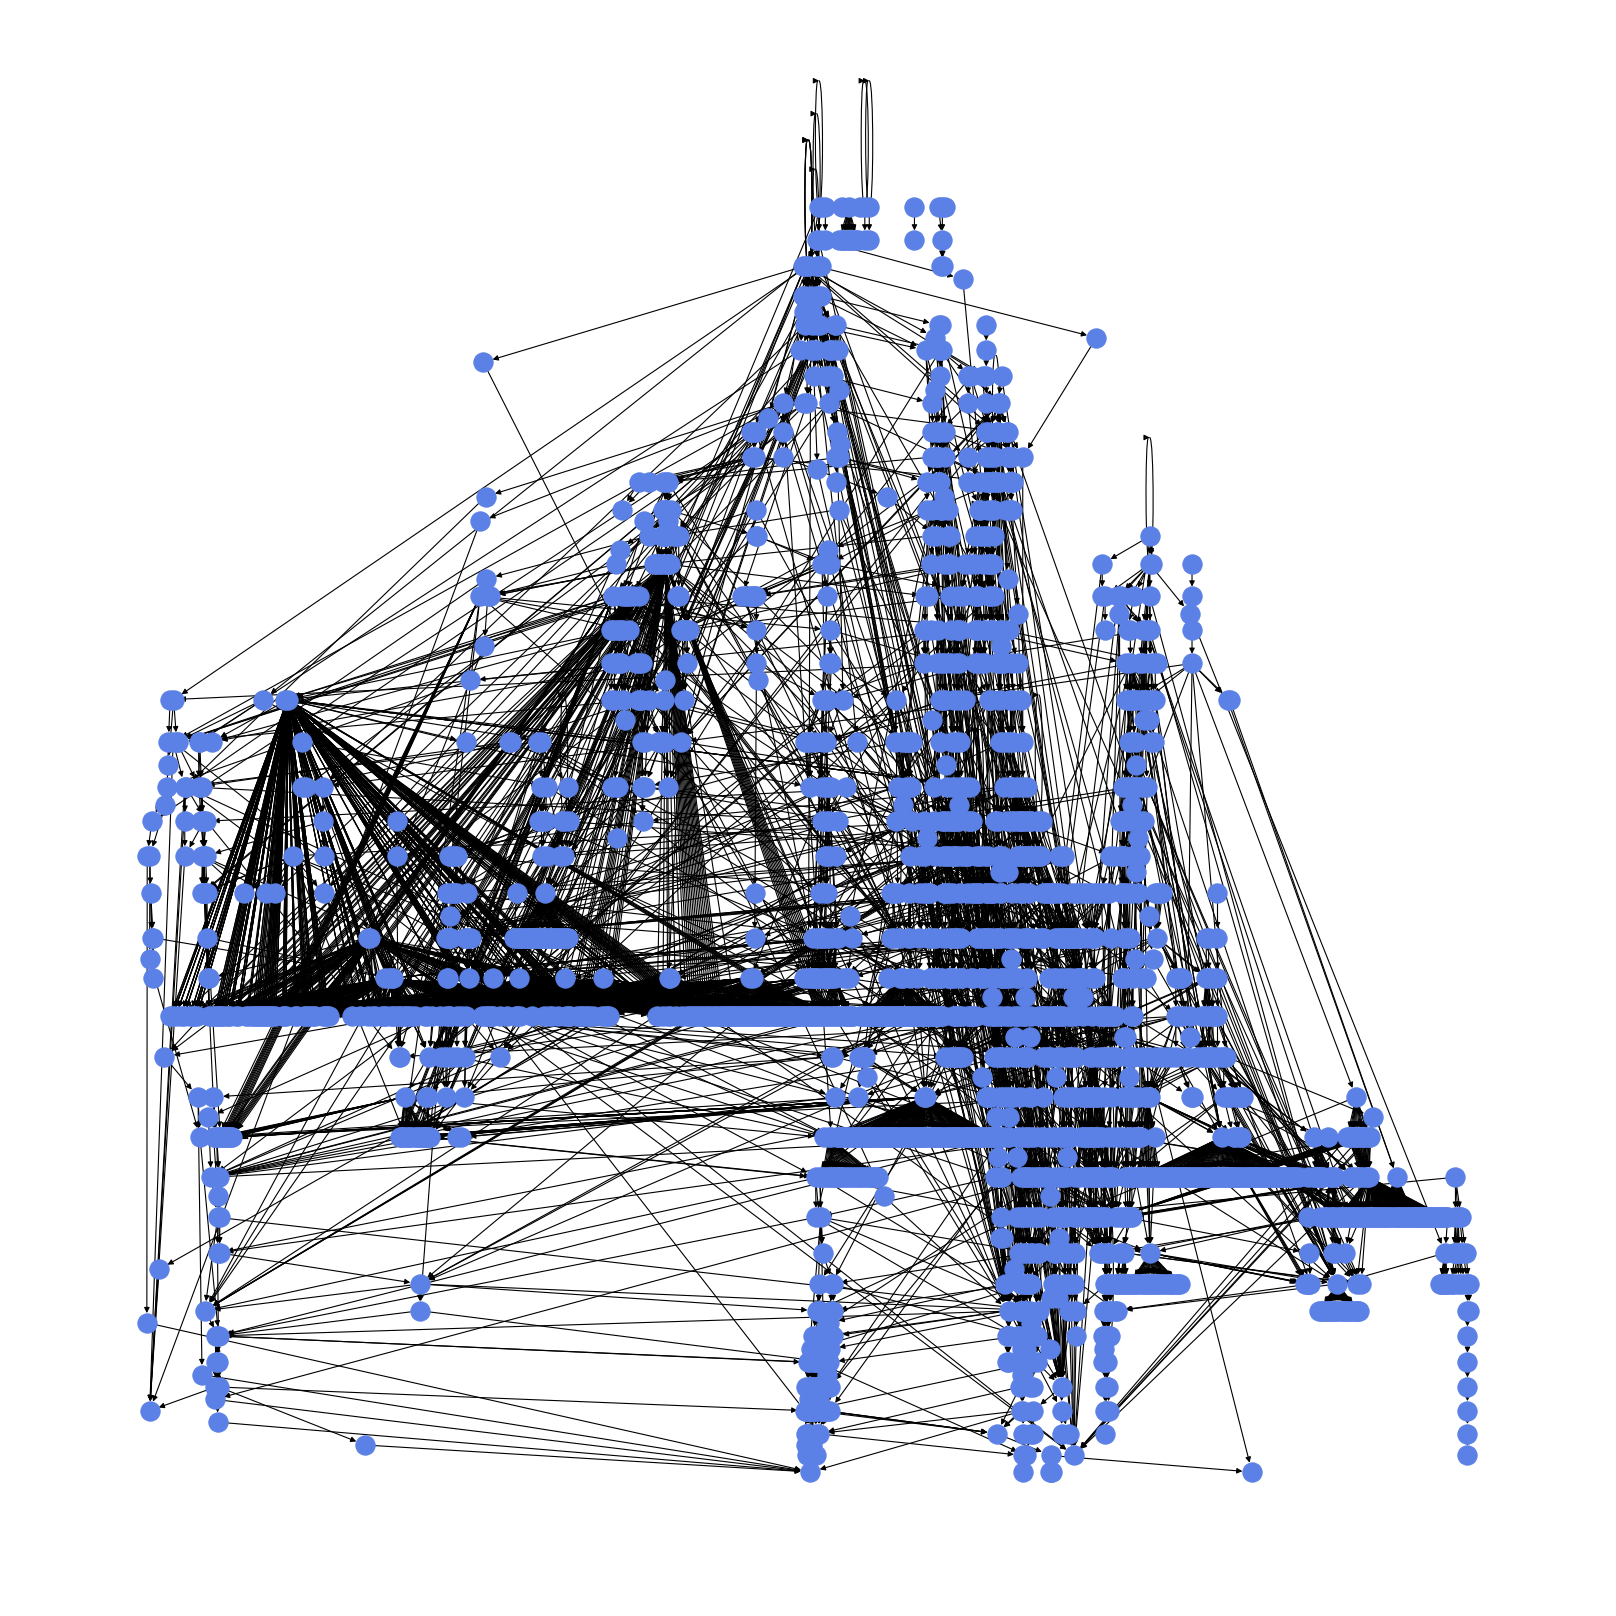

In [92]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

#### Preprocessing

In [93]:
# Remove unstable nodes where dotfile name is same as db measurement
unstable_benchmarks_idx = []
for idx, graph in enumerate(final_graphs):
    if list(ordered_graphs.keys())[idx].rsplit("_", 1)[1] in unstable_benchmarks:
        print("Removing unstable benchmark", list(ordered_graphs.keys())[idx])
        unstable_benchmarks_idx.append(idx)

print(unstable_benchmarks_idx)

Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".*",i!="2",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkRowsUnmarshal
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~"1.+",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-i=~".*"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",i!~"2.*",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",j!="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i!="",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",i!="2",j="foo"
[54, 144, 189, 246, 272, 307, 320, 482, 491]


# Reduction Algorithm

Switched for more stable benchmark
Key error BenchmarkTableAddRows-tsidsCount_100-rowsPerInsert_10 BenchmarkQueueThroughputConcurrent-block-size-100
Switched for more stable benchmark
Key error BenchmarkAggregatorsPushByJobAvg-output=stddev BenchmarkPromRegexMatchString-unpotimized-prefix-match-StandardRegex
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Key error BenchmarkAggregatorsPushByJobAvg-output=quantiles(0,_0.5,_1) BenchmarkAggregatorsPushByJobAvg-output=avg
Key error BenchmarkAggregatorsPushByJobAvg-output=count_samples BenchmarkAggregatorsPushByJobAvg-output=avg
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Key error BenchmarkStorageAddRows-rowsPerBatch_1 BenchmarkIndexDBAddTSIDs
Switched for more stable benchmark
Key error BenchmarkTableAddRows-tsidsCount_10000-rowsPerInsert_10 BenchmarkUnionNoOverlap-items_100000
Switched f

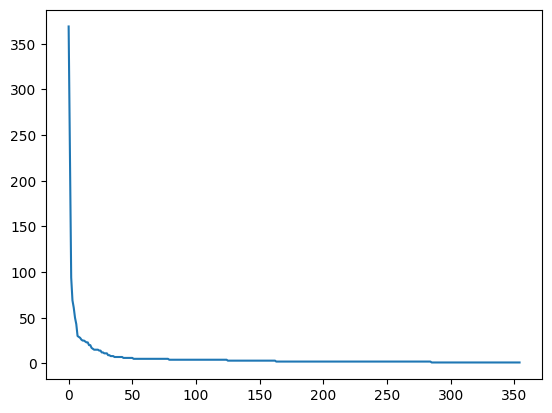

In [94]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_nodes = []
remaining_graph = full_graph.copy()
coverage_information = {}
iterations = 0
used_graph_idx = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx) or (idx in unstable_benchmarks_idx): #or (idx in failed_benchs_idx):
            continue

        overlap_nodes = np.intersect1d(list(benchmark_graph.nodes()), list(remaining_graph.nodes()))
        overlap = len(overlap_nodes)

        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.nodes())}")
        break
    
    reduce_graphs_nodes.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx.append(highest_coverage[0])
    remaining_graph.remove_nodes_from(used_graph.nodes())
    iterations += 1

plt.plot([x[1] for x in reduce_graphs_nodes])
plt.show()

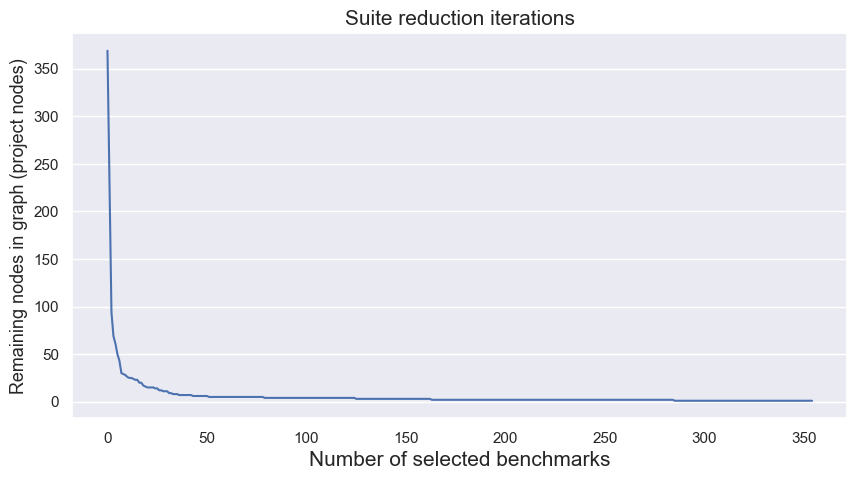

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Suite reduction iterations", fontsize=15)
plt.plot([x[1] for x in reduce_graphs_nodes])
ax.grid(axis='x', alpha=0.00)

plt.xlabel("Number of selected benchmarks", fontsize=15)
plt.ylabel("Remaining nodes in graph (project nodes)", fontsize=13)
plt.savefig('graphics/victoria_reduce.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
reduced_suite = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_nodes]

In [98]:
notFound = 0
failed_benchs_idx = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]
stabilities_new = []
stabilities_old = []
for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        stability = np.mean(stability_measures[name])
        stabilities_old.append(stability)
        if idx in reduced_idx:
            stabilities_new.append(stability)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-2-tsids-1000 -> BenchmarkPartSearch-sparseness-2-tsids-1000
KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-10-tsids-100 -> BenchmarkPartSearch-sparseness-10-tsids-100
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-100000 -> BenchmarkFastQueueThroughputConcurrent-block-size-100000
KeyError: 07-14-2023_BenchmarkAggregatorsPushByJobAvg-output=avg -> BenchmarkAggregatorsPushByJobAvg-output=avg
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-10 -> BenchmarkFastQueueThroughputConcurrent-block-size-10
KeyError: 07-14-2023_BenchmarkTableAddRows-tsidsCount_1000-rowsPerInsert_1000 -> BenchmarkTableAddRows-tsidsCount_1000-rowsPerInsert_1000
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-10000 -> BenchmarkFastQueueThroughputConcurrent-block-size-10000
KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-100-tsids-1000 -> BenchmarkPartSearch-sparseness-100-tsids-1000
KeyErr

In [99]:
print(np.mean(stabilities_old))
print(np.mean(stabilities_new))

0.06447197677292103
0.04632456585338787


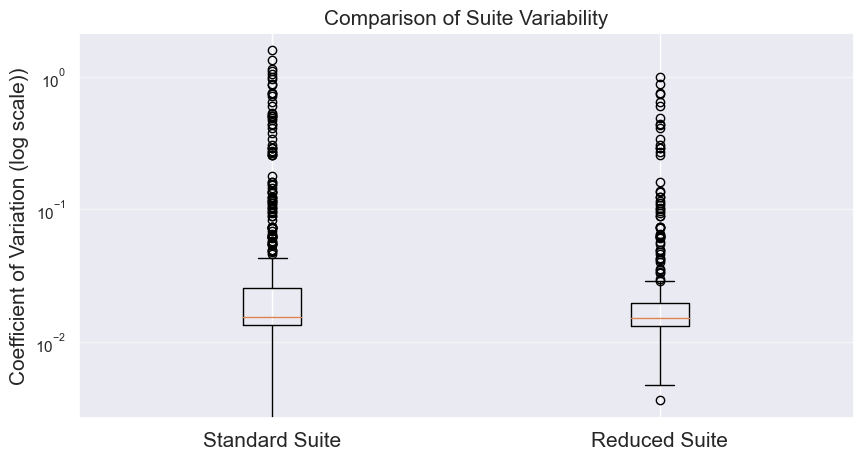

In [132]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(10, 5))
boxplot = ax.boxplot(data, positions=[1, 2]) #, labels=['Standard Suite', 'Reduced Suite'])
ax.set_xticklabels(['Standard Suite', 'Reduced Suite'], fontsize=15)
ax.set_ylabel('Values')
ax.set_title('Comparison of Suite Variability', fontsize=15)
ax.grid(axis='y', alpha=0.50)

plt.ylabel('Coefficient of Variation (log scale))', fontsize=15)
plt.yscale('log')
plt.savefig('graphics/victoria_variability.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
sns.set_theme()
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

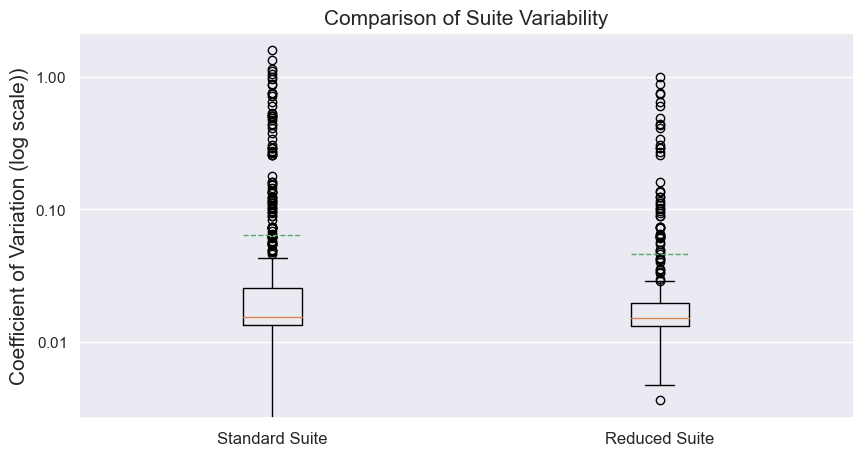

In [137]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(10, 5))
boxplot = ax.boxplot(data, positions=[1, 2], showmeans=True, meanline=True) #, labels=['Standard Suite', 'Reduced Suite'])
ax.set_xticklabels(['Standard Suite', 'Reduced Suite'], fontsize=12)
ax.set_ylabel('Values')
ax.set_title('Comparison of Suite Variability', fontsize=15)
ax.grid(axis='x', alpha=0.00)

plt.ylabel('Coefficient of Variation (log scale))', fontsize=15)
plt.yscale('log')
ax.yaxis.set_major_formatter(formatter) 
plt.savefig('graphics/victoria_variability.png', dpi=300, bbox_inches='tight')
plt.show()

In [103]:
len(reduced_idx)

355

In [102]:
found_changes = []
found_name = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes.append(perf_dict[name])
            found_name.append(name)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 07-14-2023_BenchmarkPromRegexMatchString-prefix-or-values-mismatch-PromRegex -> BenchmarkPromRegexMatchString-prefix-or-values-mismatch-PromRegex
KeyError: 07-14-2023_BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1 -> BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1
KeyError: 07-14-2023_BenchmarkOptimizedReMatchCost-.+middle.+ -> BenchmarkOptimizedReMatchCost-.+middle.+
KeyError: 07-14-2023_BenchmarkRollupAvg -> BenchmarkRollupAvg
KeyError: 07-14-2023_BenchmarkApplyRelabelConfigs-labelkeep-match -> BenchmarkApplyRelabelConfigs-labelkeep-match
KeyError: 07-14-2023_BenchmarkTableSearch-itemsCount-1000000-random-keys-without-suffix-rowsToScan-100 -> BenchmarkTableSearch-itemsCount-1000000-random-keys-without-suffix-rowsToScan-100
KeyError: 07-14-2023_BenchmarkUnixTimestamp -> BenchmarkUnixTimestamp
KeyError: 07-14-2023_BenchmarkQueueThroughputSerial-block-size-100000 -> BenchmarkQueueThroughputSerial-block-size-100

In [104]:
found_name

['BenchmarkApplyRelabelConfigs-labelmap-mismatch',
 'BenchmarkMatchRegexSingleValueMismatchUnoptimized',
 'BenchmarkQueueThroughputConcurrent-block-size-1',
 'BenchmarkHeadPostingForMatchers-j="foo",n="1"',
 'BenchmarkApplyRelabelConfigs-labelkeep-match-regexp',
 'BenchmarkCompressWriteRequestSnappy-s2-rows_1000',
 'BenchmarkUnmarshalInt64NearestDelta',
 'BenchmarkPromRegexMatchString-prefix-dot-star-mismatch-StandardRegex',
 'BenchmarkPromRegexMatchString-prefix-substring-dot-plus-match-StandardRegex',
 'BenchmarkMapHasHitRandomLastBits-lastBits_32',
 'BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1000',
 'BenchmarkCommonPrefixLen-prefix-len-0',
 'BenchmarkDeduplicateSamples-minScrapeInterval=2s',
 'BenchmarkPromRegexMatchString-unpotimized-prefix-mismatch-PromRegex',
 'BenchmarkTableSearch-itemsCount-1000000-sequential-keys-without-suffix-rowsToScan-1000',
 'BenchmarkTableSearch-itemsCount-1000000-sequential-keys-exact-rowsToScan-10',
 'BenchmarkFastS

In [105]:
for idx, x in enumerate(found_name):
    print(perf_dict[x], x)

2.4486439121180315 BenchmarkApplyRelabelConfigs-labelmap-mismatch
0.40265860801285136 BenchmarkMatchRegexSingleValueMismatchUnoptimized
0.304626949743092 BenchmarkQueueThroughputConcurrent-block-size-1
0.5399402873408343 BenchmarkHeadPostingForMatchers-j="foo",n="1"
4.032943728131877 BenchmarkApplyRelabelConfigs-labelkeep-match-regexp
1.1002108208166939 BenchmarkCompressWriteRequestSnappy-s2-rows_1000
0.011357956240010125 BenchmarkUnmarshalInt64NearestDelta
4.872916778758318 BenchmarkPromRegexMatchString-prefix-dot-star-mismatch-StandardRegex
0.2993602330595424 BenchmarkPromRegexMatchString-prefix-substring-dot-plus-match-StandardRegex
2.4743459638595255 BenchmarkMapHasHitRandomLastBits-lastBits_32
0.9474578884875906 BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1000
1.4944363812706918 BenchmarkCommonPrefixLen-prefix-len-0
0.11241336861331774 BenchmarkDeduplicateSamples-minScrapeInterval=2s
38.44579165491753 BenchmarkPromRegexMatchString-unpotimized-pre

In [106]:
print(len(found_changes))
print(len(perf_dict.keys()))

71
108


In [107]:
not_found = []
for change_b in perf_dict.keys():
    if change_b not in found_name:
        not_found.append(change_b)

print(len(not_found))
not_found

37


['BenchmarkCommonPrefixLen-prefix-len-127',
 'BenchmarkFilterHasMiss-maxItems=1000000',
 'BenchmarkMapAddWithAllocs-items_100000',
 'BenchmarkOptimizedReMatchCost-.+',
 'BenchmarkIntersectNoOverlap-items_10000',
 'BenchmarkMarshalInt64NearestDelta2-precisionBits_4',
 'BenchmarkAddMulti-items_100000',
 'BenchmarkPromRegexMatchString-dot-plus-mismatch-PromRegex',
 'BenchmarkSetAddWithAllocs-items_1000',
 'BenchmarkMapAddReuse-items_10000000',
 'BenchmarkFilterHasHit-maxItems=10000',
 'BenchmarkMapAddNoAllocs-items_1000000',
 'BenchmarkFilterHasHit-maxItems=100000',
 'BenchmarkMapHasMiss-items_10000',
 'BenchmarkUnionFullOverlap-items_1000',
 'BenchmarkMapHasHit-items_1000',
 'BenchmarkMapAddNoAllocs-items_10000000',
 'BenchmarkReaderAtMustReadAt-mmap_off-1000',
 'BenchmarkMapAddRandomLastBits-lastBits_24',
 'BenchmarkPromRegexMatchString-substring-dot-star-match-StandardRegex',
 'BenchmarkOptimizedReMatchCost-fullMatchCost',
 'BenchmarkFromFloat-0',
 'BenchmarkMergeSortBlocks-replication

In [108]:
# Check if graphs overlap with reduced suite
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_nodes = np.intersect1d(list(graph.nodes()), list(selected_graph.nodes()))

                # calculate percentage of overlap with graph
                overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                if overlap_percentage > 0.8 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
                
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]

                # calculate missing nodes
                missing_nodes = np.setdiff1d(list(graph.nodes()), list(selected_graph.nodes()))

                if highest_overlap[1] < 1.0 and False:
                    for selected in reduced_suite:
                        name1 = selected[1]
                        selected_graph = final_graphs[selected[0]]
                        overlap_nodes = np.intersect1d(missing_nodes, list(selected_graph.nodes()))

                        # calculate percentage of overlap with graph
                        overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                        if overlap_percentage > 0.5:
                            print(f"Missing nodes: {len(missing_nodes)} - Overlap: {overlap_percentage}")
                        if overlap_percentage == 1.0:
                            print(f"Missing benchmark {change} overlaps with {name} and {name1}")
                            newly_found.add(change)
                else:       
                    print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]} - Missing nodes: {len(missing_nodes)}")
                    newly_found.add(change)

                # Plot graphs
                # plt.figure(figsize=(10, 10), dpi=80)
                # pos_full2 = {k: (v[0] + 100, v[1]) for k, v in pos_full.items()}
                # nx.draw(selected_graph, pos_full, arrows=True, node_color="blue")
                # nx.draw(graph, pos_full2, arrows=True, node_color="red")
                # plt.show()

Missing benchmark BenchmarkCommonPrefixLen-prefix-len-127 overlaps with BenchmarkCommonPrefixLen-prefix-len-0: 1.0 - Missing nodes: 0
Missing benchmark BenchmarkFilterHasMiss-maxItems=1000000 overlaps with BenchmarkFilterHasMiss-maxItems=10000000: 1.0 - Missing nodes: 0
Missing benchmark BenchmarkMapAddWithAllocs-items_100000 overlaps with BenchmarkMapAddWithAllocs-items_1000: 1.0 - Missing nodes: 0
Missing benchmark BenchmarkOptimizedReMatchCost-.+ overlaps with BenchmarkTableAddRows-tsidsCount_100-rowsPerInsert_10: 0.8333333333333334 - Missing nodes: 1
Missing benchmark BenchmarkIntersectNoOverlap-items_10000 overlaps with BenchmarkIntersectNoOverlap-items_1000: 1.0 - Missing nodes: 0
Missing benchmark BenchmarkMarshalInt64NearestDelta2-precisionBits_4 overlaps with BenchmarkTableSearch-rowsCount_100000000-tsidsCount_10000-tsidsSearch_10: 0.8571428571428571 - Missing nodes: 1
Missing benchmark BenchmarkAddMulti-items_100000 overlaps with BenchmarkAddMulti-items_10000000: 1.0 - Missin

In [110]:
import re

def recalculate_percentages_based_on_seconds(graph):
    # extract seconds x.xxs using regex
    r = re.compile(r"(\d+\.\d+|\d)s")

    total_time = 0
    for node in graph.nodes(data=True):
        try:
            seconds = r.search(node[1]['label']).group(1)
            total_time += float(seconds)
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

    # recalculate percentages
    for node in graph.nodes(data=True):
        try:
            seconds = float(r.search(node[1]['label']).group(1))
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

        # calculate percentage of total time
        percentage = seconds / total_time * 100
        node[1]['totalPerc'] = percentage


# check if first graph overlaps graph 2 sufficeintly
def calculate_overlap_value(graph1, graph2):

    # Calculate percentages based on total seconds of reduced graph
    recalculate_percentages_based_on_seconds(graph1)
    recalculate_percentages_based_on_seconds(graph2)

    perc = 0
    for node in graph2.nodes(data=True):
        if node[0] in graph1.nodes():
            # print(f"Found {node[1]['label']} with {node[1]['totalPerc']}")
            perc += node[1]['totalPerc']
    return perc / 100

In [111]:
# Check if graphs overlap with reduced suite with new overlap method
matching_graphs = []
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_percentage = calculate_overlap_value(selected_graph, graph)

                if overlap_percentage > 0.95 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
            
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
            
                print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]}")
                newly_found.add(change)
                matching_graphs.append((selected_graph, graph))

There was an error extracting seconds from promrelabel\n(*graphiteMatchTemplate)\nMatch\n6040ms (39.76%)\nof 14000ms (92.17%)
There was an error extracting seconds from promrelabel\nbenchmarkGraphiteMatchTemplateMatch\nfunc1\n1190ms (7.83%)\nof 15190ms (100%)
There was an error extracting seconds from strings\nIndex\n1590ms (10.47%)\nof 3890ms (25.61%)
There was an error extracting seconds from strings\nHasSuffix\n1210ms (7.97%)\nof 2140ms (14.09%)
There was an error extracting seconds from strings\nIndexByte\n370ms (2.44%)\nof 1930ms (12.71%)
There was an error extracting seconds from bytealg\nIndexString\n600ms (3.95%)
There was an error extracting seconds from bytealg\nIndexByteString\n290ms (1.91%)
There was an error extracting seconds from indexbody\n1700ms (11.19%)
There was an error extracting seconds from indexbytebody\n1270ms (8.36%)
There was an error extracting seconds from memeqbody\n930ms (6.12%)
There was an error extracting seconds from promrelabel\n(*graphiteMatchTempla

KeyError: 'totalPerc'

In [113]:
print(len(newly_found))
newly_found

3


{'BenchmarkCommonPrefixLen-prefix-len-127',
 'BenchmarkFilterHasMiss-maxItems=1000000',
 'BenchmarkMapAddWithAllocs-items_100000'}

In [114]:
len(not_found) - len(newly_found)

34

# Visualize matches

In [126]:
graphs = matching_graphs[-4]

In [129]:
labeldict1 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[0].nodes():
        del labeldict1[key]

labeldict2 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[1].nodes():
        del labeldict2[key]

In [162]:
# how to generate gradient color values based on percentage
sum = 0
colors1 = []
for node in list(graphs[1].nodes(data=True)):
    percentage = node[1]['totalPerc'] / 100
    # percentage = round(percentage, 3)

    sum = sum + percentage

    color = (int(255 * percentage), int(255 * (1 - percentage)), 0)
    color = '#%02x%02x%02x' % color
    if node[0] not in list(graphs[0].nodes()):
        colors1.append("red")
        labeldict2[node[0]] = percentage
    else:
        colors1.append(color)
        labeldict2[node[0]] = ""

    # labeldict2[node[0]] = percentage

print(sum)

0.9999999999999979


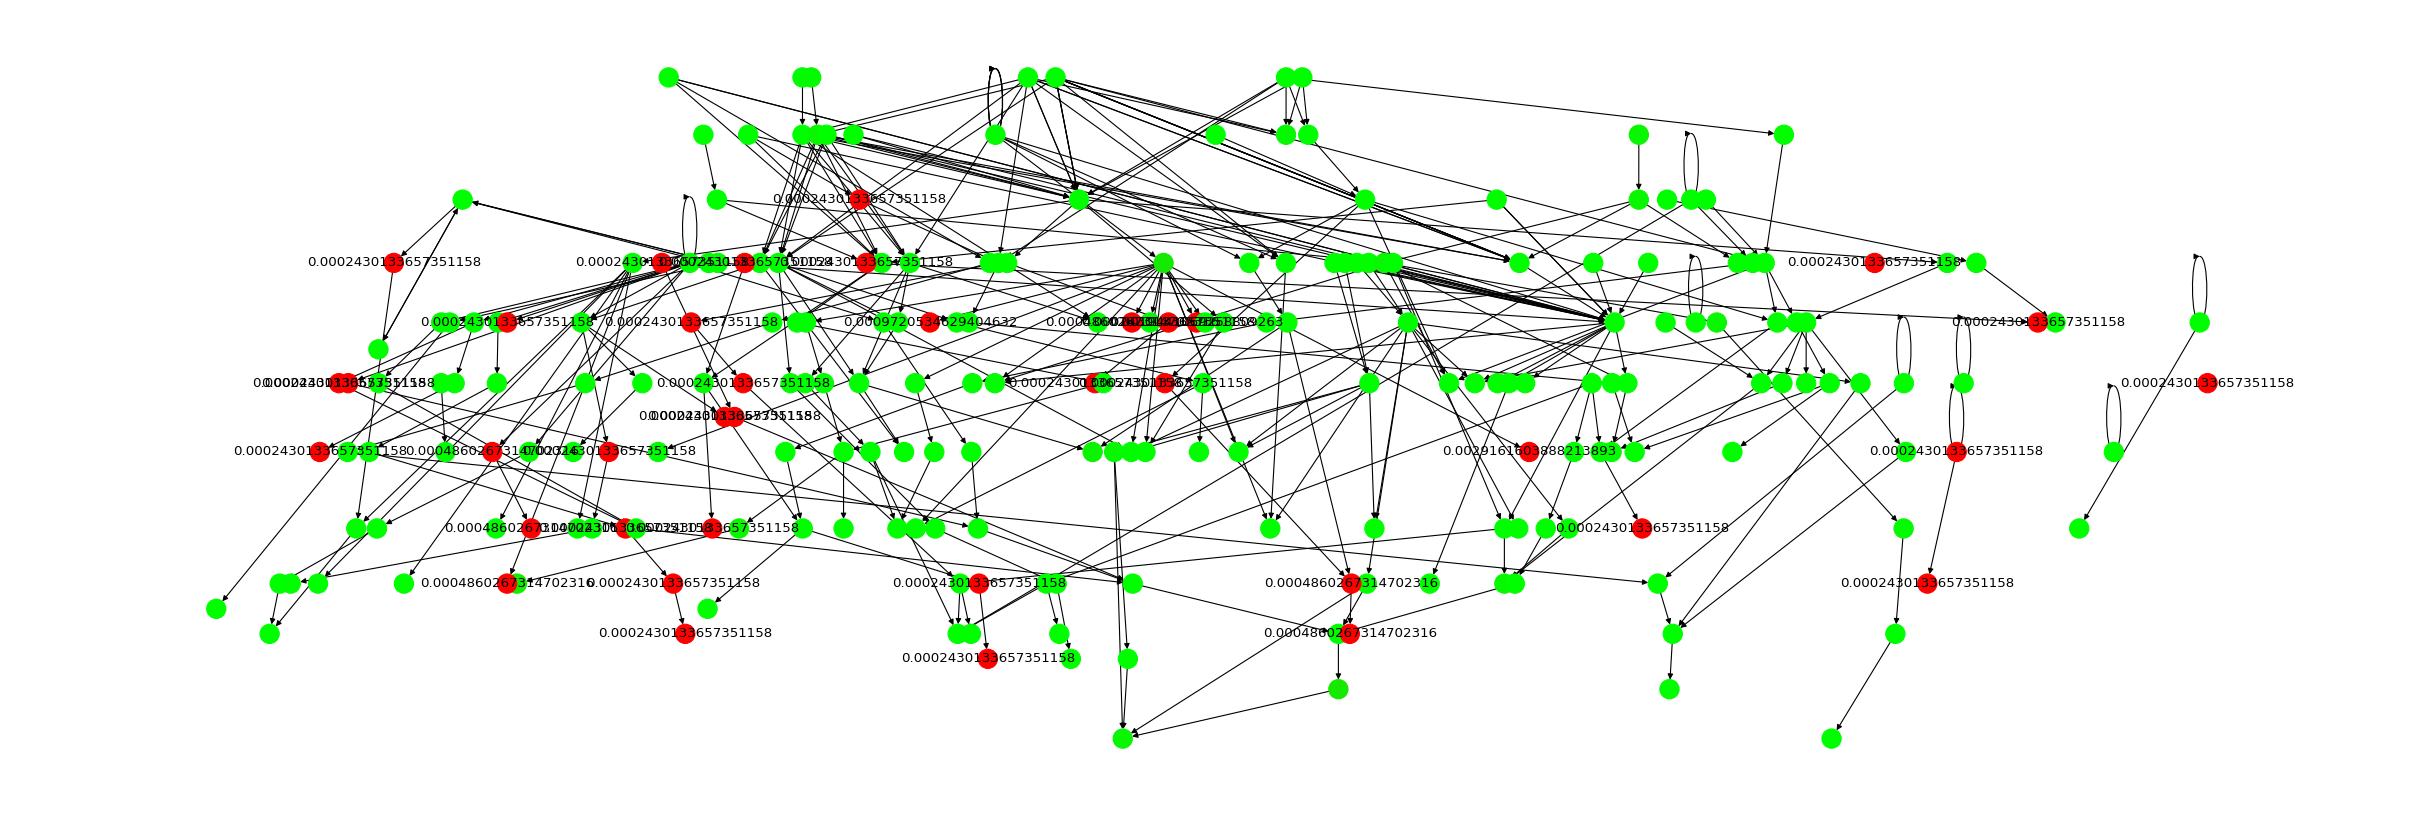

In [163]:
# plot graph with labels
plt.figure(figsize=(30, 10), dpi=80)

# shift pos full
pos_full2 = {k: (v[0] + 200, v[1]) for k, v in pos_full.items()}

# nx.draw(graphs[0], pos_full, arrows=True, node_color="green")
nx.draw(graphs[1], pos_full2, arrows=True, node_color=colors1, labels=labeldict2)
plt.show()

# Time saved

In [164]:
print("Old suite runtime in minutes:", len(final_graphs) * 5 * 3 * 1 / 60)
print("Reduced Suite runtime in minute:", len(reduced_idx) * 5 * 3 * 1 / 60)

Old suite runtime in minutes: 51.75
Reduced Suite runtime in minute: 20.5


[(<networkx.classes.multidigraph.MultiDiGraph at 0x1735f0a10>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x2829b6950>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x176cc4550>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28cc78b90>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x1748e2ad0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x173579690>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x2873e12d0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28b9e1010>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x283a37490>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28e0c5b10>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x175c7f090>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28733b610>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x176d144d0>,
  <networkx.classes.multidigraph.MultiDiGraph at